![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 399.7 KB


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1
import numpy as np
import numpy as np

# Función para calcular ganancia por reducción de varianza
def variance_gain(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    if n_l == 0 or n_r == 0:
        return 0
    
    var_total = y.var()
    var_l = y_l.var()
    var_r = y_r.var()
    
    gain = var_total - (n_l / (n_l + n_r) * var_l + n_r / (n_l + n_r) * var_r)
    
    return gain

# Función para encontrar el mejor split
def best_split_reg(X, y, num_pct=10):
    best_split = [0, 0, -np.inf]  # j, split, gain

    for j in range(X.shape[1]):
        col = X.iloc[:, j]

        # Ignorar columnas binarias o booleanas
        if col.nunique() <= 2:
            continue

        splits = np.percentile(col, np.linspace(0, 100, num_pct + 2)[1:-1])
        splits = np.unique(splits)

        for split in splits:
            gain = variance_gain(col, y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

# Función para hacer crecer el árbol manualmente (regresión)
def tree_grow_reg(X, y, level=0, min_gain=1e-5, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        return dict(y_pred=y.iloc[0], level=level, split=-1, n_samples=1, gain=0)

    j, split, gain = best_split_reg(X, y, num_pct)
    y_pred = y.mean()

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    # Criterios de parada
    if gain < min_gain:
        return tree
    if max_depth is not None and level >= max_depth:
        return tree

    # Crear divisiones
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    tree['split'] = [j, split]
    tree['sl'] = tree_grow_reg(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree['sr'] = tree_grow_reg(X_r, y_r, level + 1, min_gain, max_depth, num_pct)

    return tree

# Función para predecir
def tree_predict_reg(X, tree):
    predicted = np.zeros(X.shape[0])

    if tree['split'] == -1:
        predicted[:] = tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] > 0:
            predicted[filter_l] = tree_predict_reg(X_l, tree['sl'])
        if X_r.shape[0] > 0:
            predicted[~filter_l] = tree_predict_reg(X_r, tree['sr'])

    return predicted
tree = tree_grow_reg(X_train, y_train, max_depth=3)
y_pred = tree_predict_reg(X_test, tree)

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")



RMSE: 1935.19
MAE: 1461.35


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

RMSE del modelo Bagging: 1617.62
MAE del modelo Bagging: 1203.06


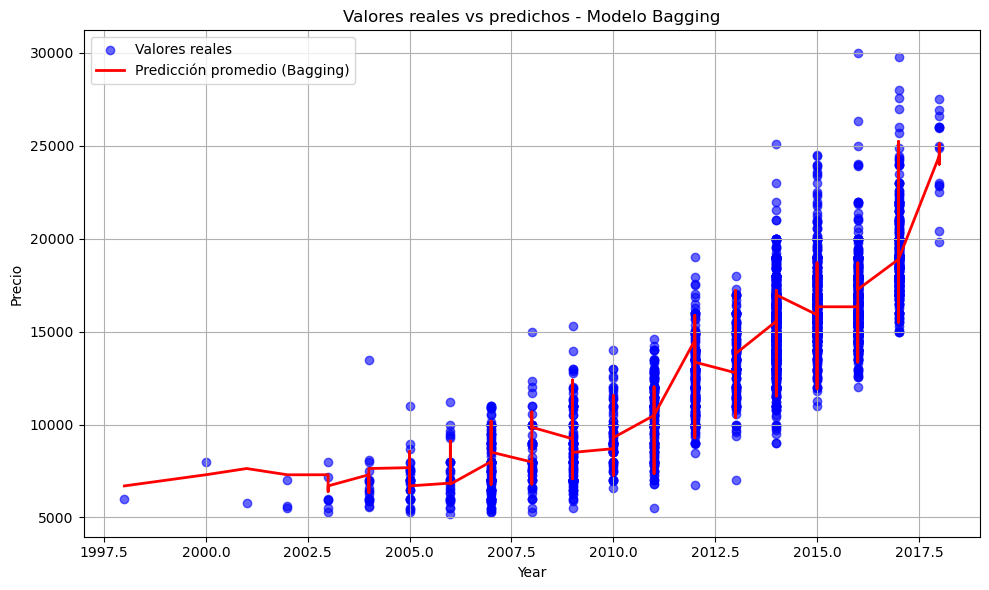

In [20]:
# Celda 2import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------
# Bagging Manual con 10 Árboles
# -------------------------------
num_trees = 10
predictions = np.zeros((X_test.shape[0], num_trees))

# Entrenar 10 árboles con subconjuntos bootstrap
for i in range(num_trees):
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    tree = DecisionTreeRegressor(max_depth=5, random_state=i)
    tree.fit(X_resampled, y_resampled)
    predictions[:, i] = tree.predict(X_test)

# Promediar las predicciones
y_pred_bagging = predictions.mean(axis=1)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmseBM = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
maeBM = mean_absolute_error(y_test, y_pred_bagging)

print(f"RMSE del modelo Bagging: {rmseBM:.2f}")
print(f"MAE del modelo Bagging: {maeBM:.2f}")

# -------------------------------
# Gráfica: Reales vs Predichos
# -------------------------------
# Ordenar por una variable predictora para graficar (ej: 'Year')
predictor = 'Year'
sorted_idx = X_test[predictor].argsort()
x_sorted = X_test[predictor].iloc[sorted_idx]
y_real_sorted = y_test.iloc[sorted_idx]
y_pred_sorted = y_pred_bagging[sorted_idx]

plt.figure(figsize=(10, 6))

# Valores reales: puntos azules
plt.scatter(x_sorted, y_real_sorted, color='blue', alpha=0.6, label='Valores reales')

# Valores predichos: línea roja
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label='Predicción promedio (Bagging)')

plt.xlabel(predictor)
plt.ylabel('Precio')
plt.title('Valores reales vs predichos - Modelo Bagging')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

RMSE del modelo Bagging (sklearn): 2768.52
MAE del modelo Bagging (sklearn): 2160.78


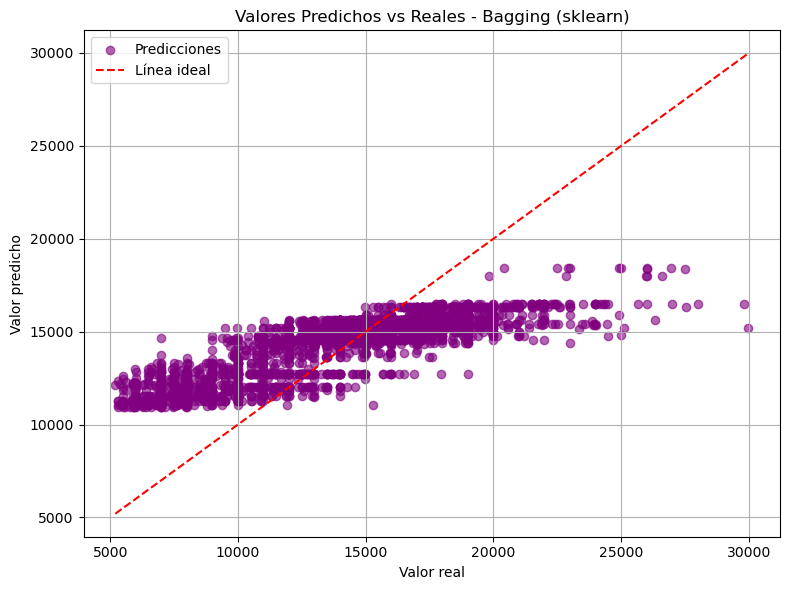

In [22]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import math

# -------------------------------
# Modelo Bagging con sklearn
# -------------------------------

# Calcular log(n_features)
n_features = X_train.shape[1]
max_features = int(np.log(n_features))

# Definir modelo Bagging

bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=10,
    max_features=max_features,
    random_state=42
)

# Entrenar modelo
bagging_model.fit(X_train, y_train)

# Predicciones
y_pred_sklearn = bagging_model.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmseBL = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
maeBL = mean_absolute_error(y_test, y_pred_sklearn)

print(f"RMSE del modelo Bagging (sklearn): {rmseBL:.2f}")
print(f"MAE del modelo Bagging (sklearn): {maeBL:.2f}")

# -------------------------------
# Gráfica: Valores predichos vs reales
# -------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_sklearn, color='purple', alpha=0.6, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Línea ideal')

plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.title('Valores Predichos vs Reales - Bagging (sklearn)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

RMSE del modelo Random Forest: 1618.40
MAE del modelo Random Forest: 1200.39


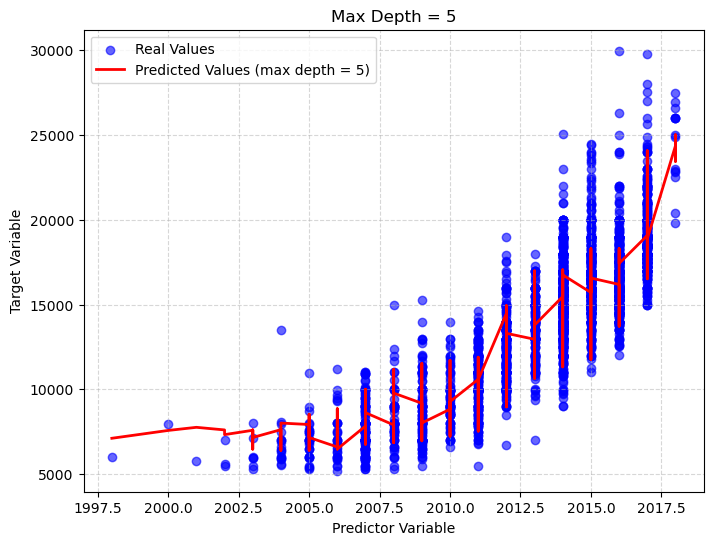

In [15]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Entrenar Random Forest Regressor
# -------------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,  # Número de árboles
    max_depth=5,  # Profundidad máxima del árbol
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"RMSE del modelo Random Forest: {rmse_rf:.2f}")
print(f"MAE del modelo Random Forest: {mae_rf:.2f}")

# -------------------------------
# Gráfica: Valores reales vs predichos
# -------------------------------
predictor = 'Year'  # Puedes cambiar 'Year' por otra variable

# Ordenar por la variable predictora
sorted_idx = X_test[predictor].argsort()
x_sorted = X_test[predictor].iloc[sorted_idx]
y_real_sorted = y_test.iloc[sorted_idx]
y_pred_sorted = y_pred_rf[sorted_idx]

plt.figure(figsize=(8, 6))

# Valores reales (puntos azules)
plt.scatter(x_sorted, y_real_sorted, color='blue', alpha=0.6, label="Real Values")

# Valores predichos (línea roja escalonada)
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label="Predicted Values (max depth = 5)")

# Título y etiquetas
plt.title("Max Depth = 5")
plt.xlabel("Predictor Variable")
plt.ylabel("Target Variable")

# Agregar leyenda y cuadrícula
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RMSE del modelo optimizado: 1564.25
MAE del modelo optimizado: 1147.20


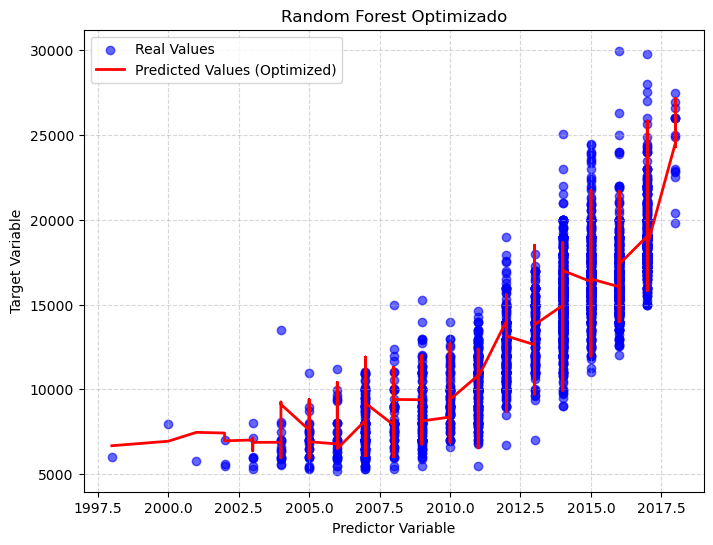

In [16]:
# Celda 5
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Definir los valores a probar en cada hiperparámetro
# -------------------------------
param_grid = {
    'n_estimators': [50, 100, 200],        # Cantidad de árboles
    'max_depth': [3, 5, 10, None],         # Profundidad máxima del árbol
    'max_features': ['sqrt', 'log2', None] # Cantidad de features por árbol
}

# Modelo base
rf_base = RandomForestRegressor(random_state=42)

# Búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_base, 
    param_grid=param_grid, 
    cv=5,                  # 5-fold cross-validation
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    verbose=1
)

# Entrenar búsqueda
grid_search.fit(X_train, y_train)

# Obtener mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar modelo con los mejores parámetros encontrados
rf_optimized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    random_state=42
)

rf_optimized.fit(X_train, y_train)
y_pred_rf_opt = rf_optimized.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf_opt)

print(f"RMSE del modelo optimizado: {rmse_rf_opt:.2f}")
print(f"MAE del modelo optimizado: {mae_rf_opt:.2f}")

# -------------------------------
# Gráfica: Valores reales vs predichos
# -------------------------------
predictor = 'Year'  # Puedes cambiar 'Year' por otra variable

# Ordenar por la variable predictora
sorted_idx = X_test[predictor].argsort()
x_sorted = X_test[predictor].iloc[sorted_idx]
y_real_sorted = y_test.iloc[sorted_idx]
y_pred_sorted = y_pred_rf_opt[sorted_idx]

plt.figure(figsize=(8, 6))

# Valores reales (puntos azules)
plt.scatter(x_sorted, y_real_sorted, color='blue', alpha=0.6, label="Real Values")

# Valores predichos (línea roja escalonada)
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label="Predicted Values (Optimized)")

# Título y etiquetas
plt.title("Random Forest Optimizado")
plt.xlabel("Predictor Variable")
plt.ylabel("Target Variable")

# Agregar leyenda y cuadrícula
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

RMSE del modelo XGBoost: 1547.19
MAE del modelo XGBoost: 1131.11


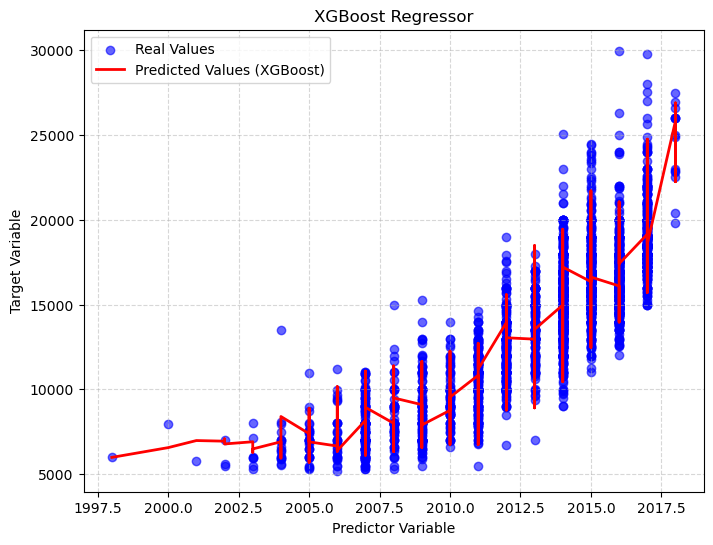

In [17]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Entrenar XGBoost Regressor
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=100,   # Número de árboles
    max_depth=5,        # Profundidad máxima del árbol
    learning_rate=0.1,  # Tasa de aprendizaje
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"RMSE del modelo XGBoost: {rmse_xgb:.2f}")
print(f"MAE del modelo XGBoost: {mae_xgb:.2f}")

# -------------------------------
# Gráfica: Valores reales vs predichos
# -------------------------------
predictor = 'Year'  # Puedes cambiar 'Year' por otra variable

# Ordenar por la variable predictora
sorted_idx = X_test[predictor].argsort()
x_sorted = X_test[predictor].iloc[sorted_idx]
y_real_sorted = y_test.iloc[sorted_idx]
y_pred_sorted = y_pred_xgb[sorted_idx]

plt.figure(figsize=(8, 6))

# Valores reales (puntos azules)
plt.scatter(x_sorted, y_real_sorted, color='blue', alpha=0.6, label="Real Values")

# Valores predichos (línea roja escalonada)
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label="Predicted Values (XGBoost)")

# Título y etiquetas
plt.title("XGBoost Regressor")
plt.xlabel("Predictor Variable")
plt.ylabel("Target Variable")

# Agregar leyenda y cuadrícula
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
RMSE del modelo optimizado: 1540.68
MAE del modelo optimizado: 1131.36


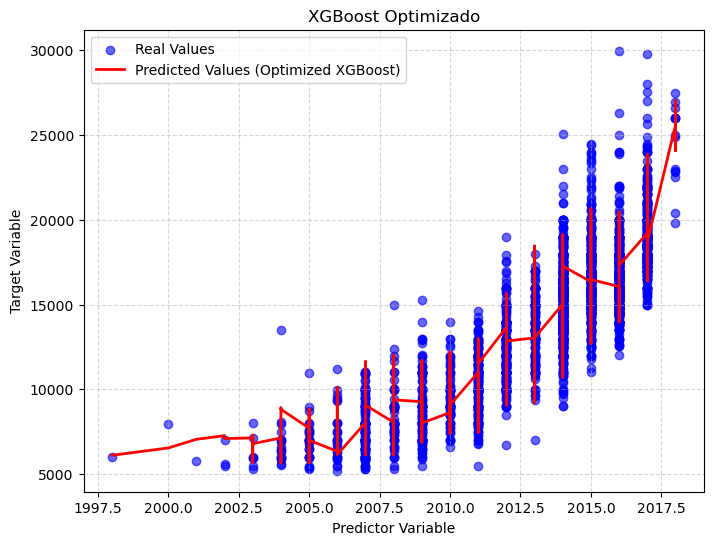

In [18]:
# Celda 7
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Definir los valores a probar en cada hiperparámetro
# -------------------------------
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Controla el tamaño del ajuste en cada iteración
    'gamma': [0, 0.1, 0.5, 1],              # Regularización para evitar sobreajuste
    'colsample_bytree': [0.5, 0.7, 1.0]     # Porcentaje de features utilizadas en cada árbol
}

# Modelo base
xgb_base = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)

# Búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_base, 
    param_grid=param_grid, 
    cv=5,                   # 5-fold cross-validation
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    verbose=1
)

# Entrenar búsqueda
grid_search.fit(X_train, y_train)

# Obtener mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar modelo con los mejores parámetros encontrados
xgb_optimized = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

xgb_optimized.fit(X_train, y_train)
y_pred_xgb_opt = xgb_optimized.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_xgb_opt = np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt))
mae_xgb_opt = mean_absolute_error(y_test, y_pred_xgb_opt)

print(f"RMSE del modelo optimizado: {rmse_xgb_opt:.2f}")
print(f"MAE del modelo optimizado: {mae_xgb_opt:.2f}")

# -------------------------------
# Gráfica: Valores reales vs predichos
# -------------------------------
predictor = 'Year'  # Puedes cambiar 'Year' por otra variable

# Ordenar por la variable predictora
sorted_idx = X_test[predictor].argsort()
x_sorted = X_test[predictor].iloc[sorted_idx]
y_real_sorted = y_test.iloc[sorted_idx]
y_pred_sorted = y_pred_xgb_opt[sorted_idx]

plt.figure(figsize=(8, 6))

# Valores reales (puntos azules)
plt.scatter(x_sorted, y_real_sorted, color='blue', alpha=0.6, label="Real Values")

# Valores predichos (línea roja escalonada)
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label="Predicted Values (Optimized XGBoost)")

# Título y etiquetas
plt.title("XGBoost Optimizado")
plt.xlabel("Predictor Variable")
plt.ylabel("Target Variable")

# Agregar leyenda y cuadrícula
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

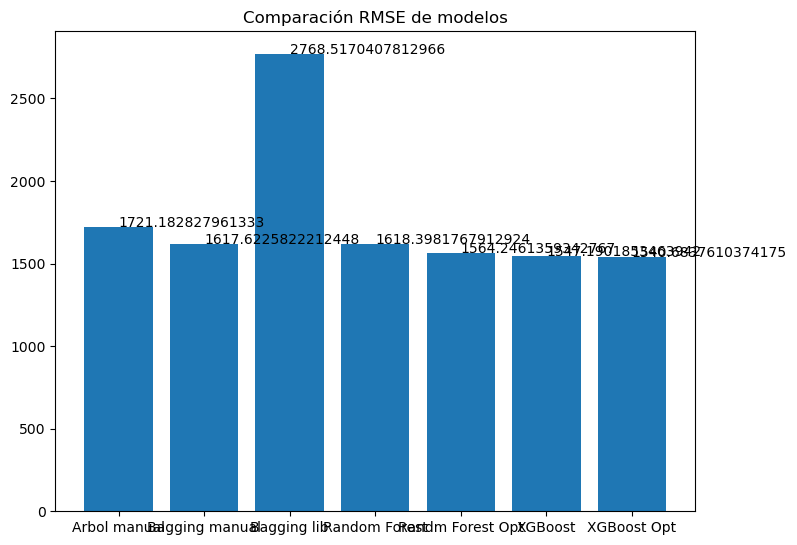

In [26]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación RMSE de modelos")
ejeX = ['Arbol manual','Bagging manual' ,'Bagging lib','Random Forest', 'Randm Forest Opt', 'XGBoost', 'XGBoost Opt']
ejeY = [rmseMT, rmseBM, rmseBL, rmse_rf, rmse_rf_opt, rmse_xgb, rmse_xgb_opt]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()